# Empirical Study of Trade Flow: a Marked Hawkes Perspective

by Zijie Gu


I realized there's a problem with my previous notebook. I had to first know the market dynamics before doing simulation with it. I therefore downloaded some trade data of my favourite crypto - Solana - from [Binance](https://data.binance.vision/)!

reference:
1. Hawkes, Alan G. “Spectra of Some Self-Exciting and Mutually Exciting Point Processes.” Biometrika, vol. 58, no. 1, 1971, pp. 83–90.

In [1]:
import pandas as pd

df = pd.read_csv("data/spot/monthly/trades/SOLUSDT/SOLUSDT-trades-2025-09.csv", names=["trade Id","price","qty","quoteQty","time","isBuyerMaker","isBestMatch"]).set_index("trade Id")
df["sign"] = df["isBuyerMaker"].map({False: +1, True: -1})
df["time"] = pd.to_datetime(df["time"], unit="us")
df = df.drop("isBuyerMaker", axis=1)
df = df.set_index("time")
df.head()

,price,qty,quoteQty,isBestMatch,sign
time,,,,,
2025-09-01 00:00:00.006980,200.62,2.490,499.54380,True,1
2025-09-01 00:00:00.411137,200.62,18.960,3803.75520,True,1
2025-09-01 00:00:00.411137,200.62,0.694,139.23028,True,1
2025-09-01 00:00:01.133976,200.61,0.027,5.41647,True,-1
2025-09-01 00:00:01.133976,200.61,0.026,5.21586,True,-1


## Hawkes v.s. Poisson: a Power Spectral Density Approach

The first question, I presume, is whether the trades in general follow a Hawkes process, and how the kernel decays.

I want to tackle this problem from the angle of power spectral density (PSD). It's well known that a Poisson process has a constant mean PSD $S$ and the mean PSD of a Hawkes process is closely related to the kernel function $\phi$ through
$$
S(\omega)=\frac{\Lambda}{|1-\mathcal{F}[\phi](\omega)|^2}
$$

where $\mathcal{F}$ is the Fourier transform.

Now computing empirical mean PSD for the raw point process data is not computationally efficient, because the uneven time series prevents me from using FFT. And therefore I first binned the data. As for the intraday seasonality, I believe the tapering window can deal with it.

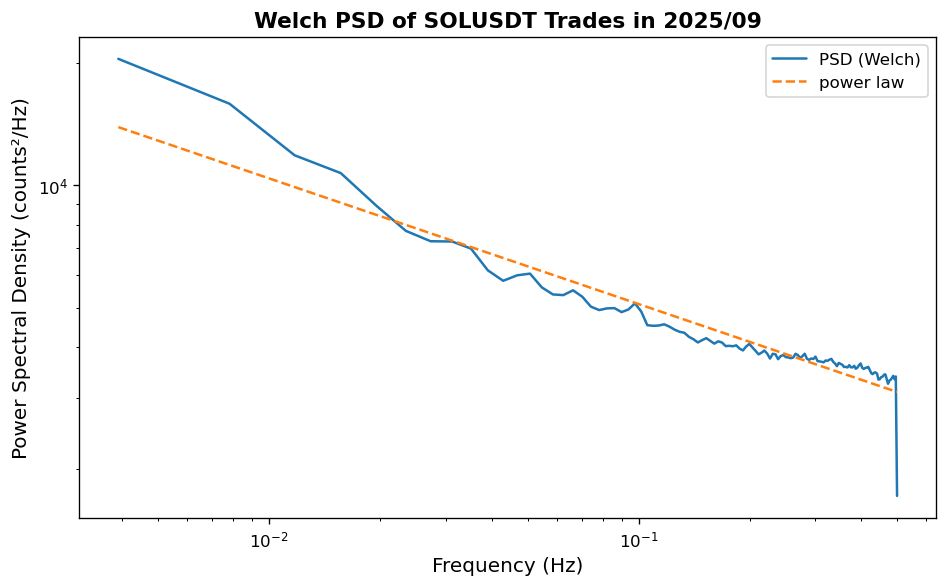

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

dt = pd.Timedelta(1, unit="s")
trade_count = df["sign"].resample(dt).count().rename("count").fillna(0)
f, Pxx = signal.welch(trade_count, fs=1.0/dt.seconds, window="hann",
                      nperseg=min(256, len(trade_count)), detrend="constant", scaling="density")
f_nz = f[f>0]
Pxx_nz = Pxx[f>0]

m, b = np.polyfit(np.log(f_nz), np.log(Pxx_nz), 1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.loglog(f_nz, Pxx_nz, linewidth=1.5, base=10, solid_capstyle="round", label="PSD (Welch)")
ax.loglog(f_nz, np.exp(m*np.log(f_nz)+b), linestyle="--", label="power law")
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Power Spectral Density (counts²/Hz)", fontsize=12)
ax.set_title("Welch PSD of SOLUSDT Trades in 2025/09", fontsize=13, weight="semibold")
ax.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

As shown in the empirical PSD, the Poisson process model clearly doesn't fit with empirical data and Hawkes process is a better fit. Moreover, the empirical PSD seems to decay as a power law, which stongly suggests that the kernel function is a power law kernel.

## Nonparametric Estimation of Marked Hawkes Kernel

If we model the trade flow as a bivariate marked Hawkes process
$$
\lambda_a(t)=\mu_a+\sum_{b\in\set{+,-}}\int_0^t\int_V\phi_{ba}(t-s,v)N_b(\mathrm{d}s,\mathrm{d}v),a\in\set{+,-}
$$

then the kernels can be empirically estimated through
$$
\phi_{ba}(\tau_l,v_m)=\frac{1}{N_b(v_m)\Delta\tau}\sum_{i:s_i=b,v_i\in \text{bin }m}|\set{j:s_j=a,t_j\in(t_i+\tau_l,t_i+\tau_l+\Delta\tau)}|,a,b\in\set{+,-}
$$

where
- $\tau_l,v_m$ are binned values of interarrival time $\tau$ and order volume
- $\Delta\tau$ is the length of $\tau$-bin
- $N_b(v_m)$ is number of events of sign $b$ whose volume falls in bin $m$

In [3]:
import itertools
import more_itertools
import numpy as np
from tqdm import tqdm

# to numpy
sign = df["sign"].to_numpy()
log_vol = np.log(df["qty"].to_numpy())
time = (df.index - df.index[0]).total_seconds().to_numpy()


# volume bins
log_vol_bins = np.unique(np.quantile(log_vol, np.linspace(0.0, 1.0, 21)))
print(log_vol_bins)

# tau bins
tau_min = 0.1 # 0.1s
tau_max = 600 # 600s
tau_bins = np.logspace(np.log10(tau_min), np.log10(tau_max), 51)

# empirical kernel phi has shape (2,2,#tau_bins,#vol_bins), first is b, second is a
sign_to_index = {-1: 0, +1: 1}
v_idx = np.digitize(log_vol, log_vol_bins) - 1
phi = np.zeros((2, 2, len(tau_bins)-1,len(log_vol_bins)-1))
N_b = np.zeros((2, len(log_vol_bins)-1), dtype=int)
for b, a in itertools.product({-1, +1}, {-1, +1}):
    b_idx = sign_to_index[b]
    a_idx = sign_to_index[a]
    mask_b = (sign == b) & (v_idx >= 0) & (v_idx < len(log_vol_bins)-1)
    times_a = time[sign==a]
    for m in tqdm(range(len(log_vol_bins)-1)):
        idx_i = np.nonzero(mask_b & (v_idx == m))[0]
        N_b[b_idx, m] = idx_i.size
        if idx_i.size == 0:
            tqdm.write(f"Skipping volume {log_vol_bins[m]}~{log_vol_bins[m+1]} because no trade is found")
            continue
        t_i = time[idx_i]
        for l_idx, (tau1, tau2) in enumerate(more_itertools.pairwise(tau_bins)):
            left = np.searchsorted(times_a, t_i + tau1, side="right")    # events > t_i+tau1
            right = np.searchsorted(times_a, t_i + tau2, side="left")  # <= t_i+tau2
            counts = (right - left).sum()
            if counts <= 0:
                tqdm.write(f"Count <= 0 at ({b},{a},{tau1}~{tau2},{log_vol_bins[m]}~{log_vol_bins[m+1]})")
            phi[b_idx, a_idx, l_idx, m] = counts / (N_b[b_idx, m] * (tau2 - tau1))
print(phi)

[-6.90775528 -3.81671283 -3.77226106 -3.72970145 -3.68887945 -3.64965874
 -3.61191841 -3.29683737 -2.57702194 -1.39030238 -0.02942881  0.93609336
  2.11806111  9.48729794]


100%|██████████| 13/13 [04:57<00:00, 22.89s/it]

[[[[ 87.53082601  97.31035087 114.05007077 ... 101.30595245
    105.57973496 129.66064154]
   [ 70.38742383  74.33104991  86.68072763 ...  84.08019379
     88.06530318 112.05891166]
   [ 60.60135934  67.13931569  80.07228796 ...  79.24700378
     80.48120383  96.53569562]
   ...
   [ 15.49826076  16.2901857   21.66138884 ...  16.66803876
     16.58645798  18.86549179]
   [ 15.20984497  15.96223306  21.06425355 ...  16.23237982
     16.1918992   18.2701998 ]
   [ 15.12297308  15.84113266  20.93296746 ...  15.94449801
     15.89150942  17.74298348]]

  [[ 19.97674783  16.13314006  23.24798703 ...  32.77743907
     33.22029622  57.01627171]
   [ 18.53027008  15.43840806  23.07252131 ...  30.3106465
     30.95355436  52.14224461]
   [ 17.3716696   14.56143402  22.34631136 ...  29.95722966
     29.70847577  48.38641992]
   ...
   [ 16.77521331  17.37753862  22.76752809 ...  18.48077303
     18.21307359  20.85947892]
   [ 16.60264734  17.02716986  22.33144423 ...  17.99539157
     17.7939238

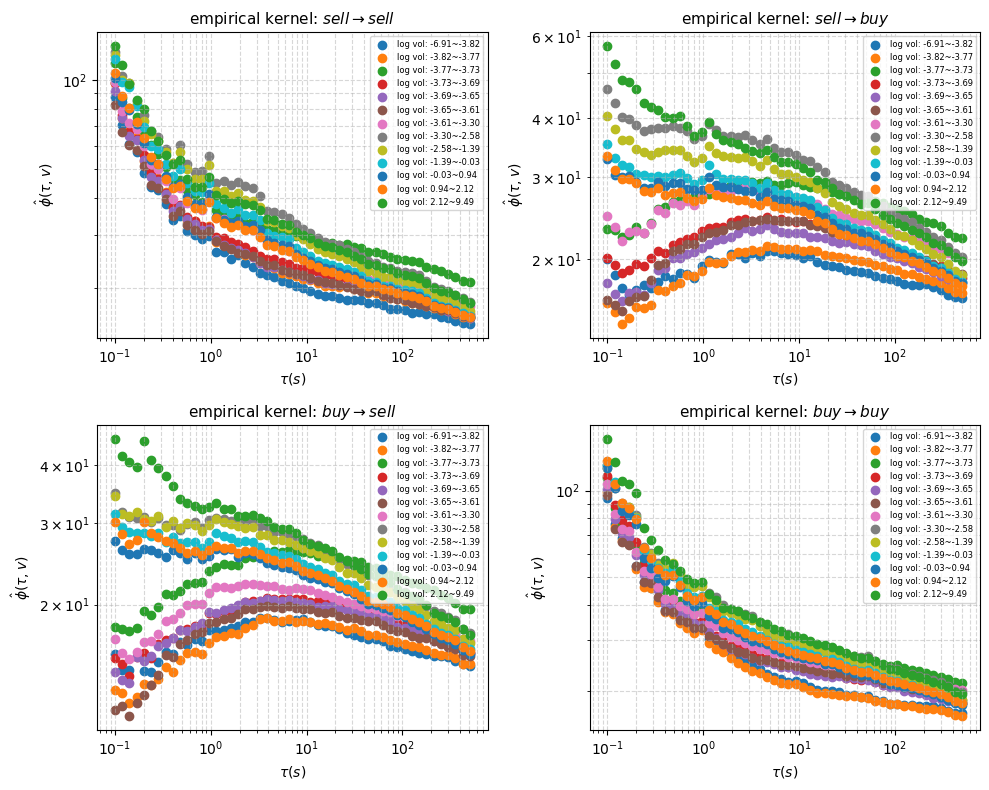

In [13]:
from matplotlib import pyplot as plt
import itertools
import more_itertools

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
xlabel = r"$\tau (s)$"
ylabel = r"$\hat{\phi}(\tau,v)$"
sign_to_index = {-1: 0, +1: 1}
sign_to_str = {-1: "sell", +1: "buy"}
for b, a in itertools.product({-1, +1}, {-1, +1}):
    b_idx = sign_to_index[b]
    a_idx = sign_to_index[a]
    ax = axes[b_idx][a_idx]
    for m, (log_v1, log_v2) in enumerate(more_itertools.pairwise(log_vol_bins)):
        ax.scatter(tau_bins[:-1], phi[b_idx, a_idx, :, m], label=f"log vol: {log_v1:.2f}~{log_v2:.2f}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(fr"empirical kernel: ${sign_to_str[b]} \to {sign_to_str[a]}$", fontsize=11)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=6)
    ax.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

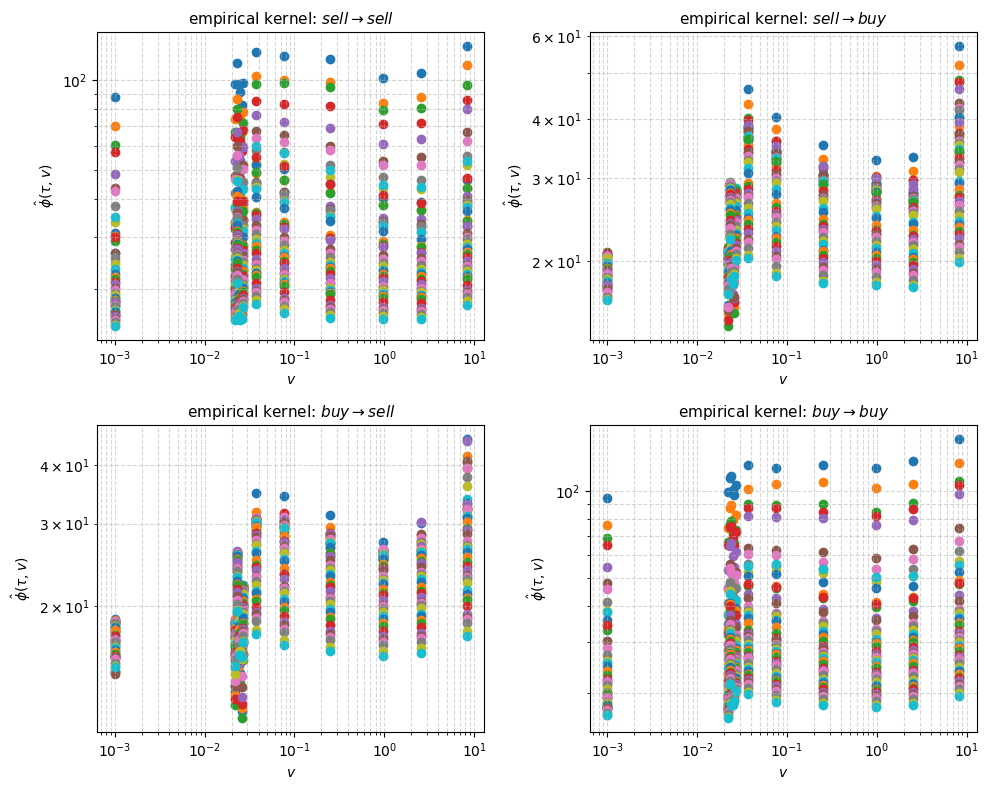

In [22]:
from matplotlib import pyplot as plt
import itertools
import more_itertools
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
xlabel = r"$v$"
ylabel = r"$\hat{\phi}(\tau,v)$"
sign_to_index = {-1: 0, +1: 1}
sign_to_str = {-1: "sell", +1: "buy"}
for b, a in itertools.product({-1, +1}, {-1, +1}):
    b_idx = sign_to_index[b]
    a_idx = sign_to_index[a]
    ax = axes[b_idx][a_idx]
    for l, (tau1, tau2) in enumerate(more_itertools.pairwise(tau_bins)):
        ax.scatter(np.exp(log_vol_bins)[:-1], phi[b_idx, a_idx, l, :], label=fr"$\tau$: {tau1:.2f}~{tau2:.2f}")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(fr"empirical kernel: ${sign_to_str[b]} \to {sign_to_str[a]}$", fontsize=11)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.legend(fontsize=6)
    ax.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

From these estimated kernels, we can see some patterns:
1. The two self-impact kernels exhibit very similar behaviors, as do the two cross-impact kernels, regardless of trade sign or direction. However, self-impacts and cross-impacts display distinct functional forms from one another.
2. On the log scale, the kernel appears roughly separable, suggesting a structure of the form $f(\tau)g(v)$.
3. For large $\tau$, the kernel decays approximately as a power law in $\tau$, while for smaller $\tau$ it exhibits a different regime, possibly reflecting short-term microstructural effects.
4. The impact of $v$ is relatively weak for self-impacts—aside from the general trend that larger $v$ yields larger amplitude—but shows a more complex and less regular pattern for cross-impacts.